# Kwantyzacja kolorów

![image-4.png](attachment:image-4.png)

## Wstęp
Standardowy kolorowy obraz rozmiarów $n \times m$ jest reprezentowany przez $n \cdot m \cdot 3$ liczb całkowitych z przedziału $[0, 255]$. Daje to łącznie ponad 16 milionów możliwych kolorów. Kwantyzacja kolorów polega na drastycznym zredukowaniu liczby używanych kolorów w celu redukcji rozmiaru pliku, przy jednoczesnym jak najlepszym zachowaniu jakości obrazu.
Najprostszą metodą kwantyzacji jest użycie metody $k$-means. Działa znakomicie jeśli chodzi o redukcję kolorów, jednak jej natura wpływa też na ostateczny wygląd obrazka:


![image.png](attachment:image.png)


Metoda ([$k$-means](https://en.wikipedia.org/wiki/K-means_clustering)) kwantyzuje obraz minimalizując błąd średniokwadratowy ([mean squared error - MSE](https://en.wikipedia.org/wiki/Mean_squared_error)) pomiędzy oryginalnym a zrekonstruowanym obrazkiem.
Jednakże zupełnie nie obchodzi jej jakich kolorów ostatecznie użyje. Okazuje się jednak, że jeśli narzucimy koszty użycia kolorów to będziemy w stanie wpłynąć na jakość kwantyzacji. Wtedy jednak metoda $k$-means nie będzie już optymalna.

Zmiana metody kwantyzacji może więc wpłynąć na ostateczną jakość skwantyzowanego obrazu. I o tym właśnie jest poniższe zadanie.


## Zadanie

Celem zadania jest napisanie algorytmu klasteryzacji, który minimalizuje inną funkcję celu niż $k$-means.
Na początek zdefiniujmy sobie *koszt koloru*. Kolor RGB rozumiemy jako wektor trójwymiarowy ze zbioru $[0,1,...,255]^3$, a koszt koloru $c$ zdefiniujemy jako
odległość euklidesową od najbliższego "prostego" koloru w przestrzeni RGB, gdzie prostymi kolorami nazywamy: czarny $(0,0,0)$, biały $(255,255,255)$, czerwony $(255,0,0)$, zielony $(0,255,0)$, niebieski $(0,0,255)$, żółty $(255,255,0)$, magenta $(255,0,255)$ oraz cyjan $(0,255,255)$. Szczegóły znajdziesz w funkcji `color_cost`.
Z tak zdefiniowaną funkcją kosztu najbardziej kosztowny kolor to $(127,127,127)$, czyli szary.
Interpretacja tej funkcji kosztu jest więc taka, że będziemy chcieli wymusić na algorytmie kwantyzacji, aby preferował kolory, które są bardziej jaskrawe i żywe.

Naszą funkcją celu będzie ważona suma poszczególnych składników:
1. `MSE`: błąd średniokwadratowy pomiędzy oryginalnym a zrekonstruowanym obrazkiem --- ten składnik odpowiada za to, żeby skwantyzowany obraz był bliski oryginałowi.
2. `max_color_cost`: największy z kosztów użytych kolorów --- ten składnik wzmacnia jaskrawość kolorów, poprzez kontrolę najmniej jaskrawego koloru.
3. `mean_color_cost`: średni koszt koloru liczony po wszystkich pikselach --- ten składnik wymusza, aby użyte kolory były średnio odpowiednio jaskrawe.

Ostatecznym kryterium jakości kwantyzacji będzie $$2\cdot MSE  + 21\cdot max\_color\_cost + 42\cdot mean\_color\_cost.$$

Powyższe kryterium i wszystkie funkcje, o których powyżej jest mowa, są zaimplementowane poniżej przez nas.

W zadaniu zakładamy, że liczba kolorów jest z góry ustalona i wynosi $37$. Twój algorytm ma więc skwantyzować obraz na $37$ kolorów w taki sposób, aby zminimalizować powyższą funkcję celu.


## Ograniczenia
- W tym zadaniu możesz korzystać z GPU.
- Twoja funkcja powinna zwracać 5 skwantyzowanych obrazów w maksymalnie 3 minuty używając Google Colab z GPU.
- Zarówno oryginalny i skwantyzowany obrazek powinny być podane do funkcji ewaluacyjnej jako `np.array` typu `np.uint8` z wartościami z przedziału $[0, 255]$.

## Uwagi i wskazówki
- Każdy obrazek to indywidualny zbiór treningowy; podczas ewaluacji nie będą wczytywane żadne wagi wytrenowanych przez Ciebie modeli.
- Będziesz pracować na obrazach wygenerowanych przez DALL-E oraz Stable Diffusion.
- W funkcji `your_quantization_algorithm` należy ustawić seeda, aby wyniki otrzymane na zbiorze treningowym i walidacyjnym przenosiły się na testowy.

## Pliki zgłoszeniowe
Tylko ten notebook.

## Ewaluacja
Pamiętaj, że podczas sprawdzania flaga `FINAL_EVALUATION_MODE` zostanie ustawiona na `True`. Za pomocą skryptu `evaluation_script.py` będziesz mógł upewnić się, że Twoje rozwiązanie zostanie prawidłowo wykonane na naszych serwerach oceniających.

Za to zadanie możesz zdobyć pomiędzy 0 i 1.5 punktu. Jeśli dostaniesz score powyżej 8900, to dostaniesz 0, a jeśli poniżej 8000, to dostaniesz 1.5 punktu. Pomiędzy tymi wartościami, Twój wynik maleje liniowo z wartością score.



# Kod startowy

In [13]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI PODCZAS WYSYŁANIA ##########################
FINAL_EVALUATION_MODE = False
# W czasie sprawdzania Twojego rozwiązania, zmienimy tę wartość na True
# Wartość tej flagi M U S I zostać ustawiona na False w rozwiązaniu, które nam nadeślesz!

In [14]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################
import os
import numpy as np
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import typing

import glob

## Ładowanie danych

In [15]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Klasa, która ułatwia wczytywanie obrazków z danego folderu
class ImageDataset:
    def __init__(self, image_dir: str):
        self.filelist = glob.glob(image_dir + "/*.jpg")
        self.IMAGE_DIMS = (512, 512)

    def __len__(self):
        return len(self.filelist)

    def __getitem__(self, idx) -> np.ndarray:
        with Image.open(self.filelist[idx]) as image:
            image = image.convert('RGB')
            image = image.resize(self.IMAGE_DIMS)
            return np.array(image)

    def __iter__(self) -> typing.Iterator[np.ndarray]:
        return (self[i] for i in range(len(self.filelist)))

## Kod z kryterium oceniającym

In [16]:
######################### NIE ZMIENIAJ TEJ KOMÓRKI ##########################

# Poniżej znajdziesz definicje MSE oraz kosztu użycia kolorów
# Pamiętaj, żeby przy ewaluacji liczyć je w przestrzeni RGB, tzn. na wartościach całkowitych z przdziału [0, 255]
# Skalowanie jest dopuszczalne tylko podczas treningu!

# Zdefiniujmy kryterium oceny jakości kwantyzacji
# Użyjemy do tego błędu średniokwadratowego (mean square error - MSE)
def mse(img, img_quant):
  return ((img_quant.astype(np.float32) - img.astype(np.float32))**2).mean()


# Następnie zdefinujmy koszt użycia kolorów
# Im bliżej danemu kolorowi do "prostych" kolorów, tym mniejszy koszt jego użycia
def color_cost(img_quant):
    vertices = np.array([
        [0, 0, 0], [0, 0, 255], [0, 255, 0], [0, 255, 255],
        [255, 0, 0], [255, 0, 255], [255, 255, 0], [255, 255, 255]
    ])

    pixels = img_quant.reshape(-1,3)

    differences = pixels[:, np.newaxis, :] - vertices[np.newaxis, :, :]
    squared_distances = np.sum(differences**2, axis=2)
    costs = np.sqrt(np.min(squared_distances, axis=1))

    return np.mean(costs), np.max(costs)


# Całkowite kryterium zdefiniowane w treści zadania
def quantization_score(img, img_quant):
    assert img.dtype == np.uint8
    assert img_quant.dtype == np.uint8
    assert len(np.unique(img_quant.reshape(-1,3), axis=0)) == 37

    mse_cost = mse(img, img_quant)
    mean_color_cost, max_color_cost = color_cost(img_quant)
    score = mse_cost * 2 + max_color_cost * 21 + mean_color_cost * 42
    print(f'MSE: {mse_cost:.4f}, max_color_cost: {max_color_cost:.4f}, mean_color_cost: {mean_color_cost:.4f}')
    print(f'Score: {score:.4f}')
    return score

# Twoje rozwiązanie

Ta sekcja to miejsce na Twoje rozwiązanie. Tylko tutaj powinieneś wprowadzać zmiany!

In [17]:
import torch

cuda_available = torch.cuda.is_available()
device = torch.device("cuda" if cuda_available else "cpu")

print(f"Używane urządzenie: '{device}'")

Używane urządzenie: 'cuda'


In [18]:
def euclidean_distance(p1,p2):
    point1 = p1.astype(np.float32)
    point2 = p2.astype(np.float32)

    diff = point1 - point2

    distance = (np.sum(diff ** 2))**0.5

    return distance

In [19]:
def find_middle_point(p1,p2):
    point1 = p1.astype(np.float32)
    point2 = p2.astype(np.float32)

    midpoint = (point1 + point2) / 2
    midpoint = np.round(midpoint).astype(np.uint8)

    return midpoint

In [20]:
lightweight_colors = np.array([
    [0,0,0],
    [255,255,255],
    [255,0,0],
    [0,255,0],
    [0,0,255],
    [255,255,0],
    [0,255,255],
    [255,0,255]
], dtype=np.uint8)

In [21]:
def your_quantization_algorithm(img):
    #TODO - poniżej zaprezentowana jest implementacja algorytmu kwantyzacji za pomocą k-means warta 0 punktów
    #TODO - zaimplementuj swój własny algorytm kwantyzacji
    from sklearn.cluster import KMeans

    pixels = img.reshape(-1, 3)
    kmeans = KMeans(n_clusters=37, random_state=0).fit(pixels)
    colors = kmeans.cluster_centers_

    new_colors = []

    for color in colors:
        distances = np.array([euclidean_distance(color,lw) for lw in lightweight_colors])
        closest = np.argmin(distances)

        new_colors.append(find_middle_point(color,lightweight_colors[closest]))

    new_colors = np.array(new_colors, dtype=np.uint8)

    labels = kmeans.predict(pixels)

    quantized_image = new_colors[labels].reshape(img.shape)
    return quantized_image.astype(np.uint8)

# Ewaluacja

Poniższy kod będzie służył ewaluacji rozwiązania. Po wysłaniu rozwiązania do nas zostanie wykonana funkcja `evaluate_algorithm(your_quantization_algorithm, 'test_data')`, t.j. prawie identyczny kod jak niżej będzie się uruchamiał na katalogu zdjęć `test_data` dostępnym tylko dla sprawdzających zadania.

Upewnij się przed wysłaniem, że cały notebook wykonuje się od początku do końca bez błędów i bez ingerencji użytkownika po wykonaniu polecenia `Run All`.

In [22]:
# Wyświetl zestawienie oryginału i zkwantyzowanego obrazka
def show_quantization_results(original, quantized):
        _, ax = plt.subplots(1, 2, figsize=(8, 4))
        ax[0].imshow(original)
        ax[0].set_title("Oryginał")
        ax[0].axis("off")

        ax[1].imshow(quantized)
        ax[1].set_title("Wynik kwantyzacji")
        ax[1].axis("off")
        plt.show()

In [23]:
def evaluate_algorithm(quantization_algorithm, data_dir):
    dataset = ImageDataset(data_dir)
    scores = []
    for image in dataset:
        quantized_image = quantization_algorithm(image)
        show_quantization_results(image, quantized_image)
        score = quantization_score(image, quantized_image)
        scores.append(score)

    return np.mean(scores)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


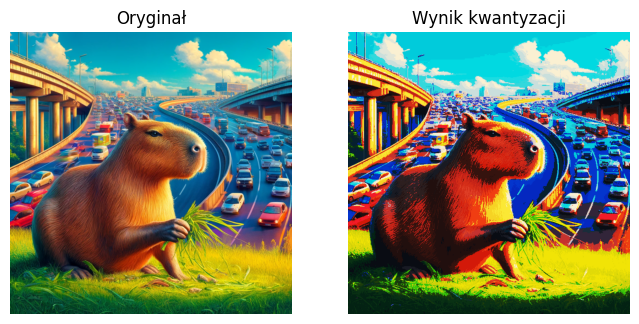

MSE: 1502.6305, max_color_cost: 96.8762, mean_color_cost: 61.2762
Score: 7613.2624


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


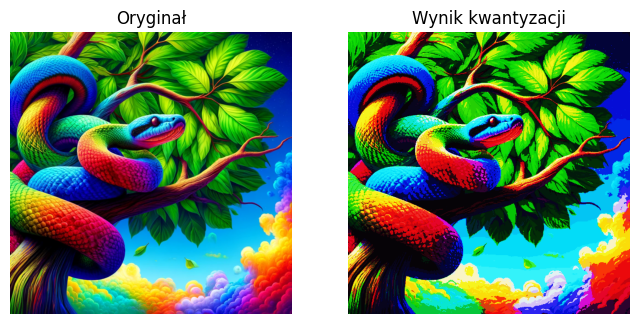

MSE: 1075.7167, max_color_cost: 87.5614, mean_color_cost: 46.2498
Score: 5932.7165


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


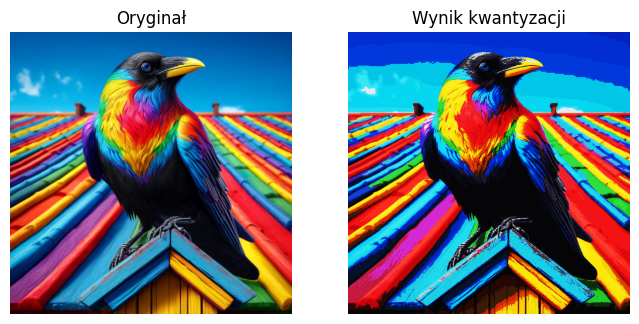

MSE: 1214.5071, max_color_cost: 95.5458, mean_color_cost: 51.5905
Score: 6602.2752


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


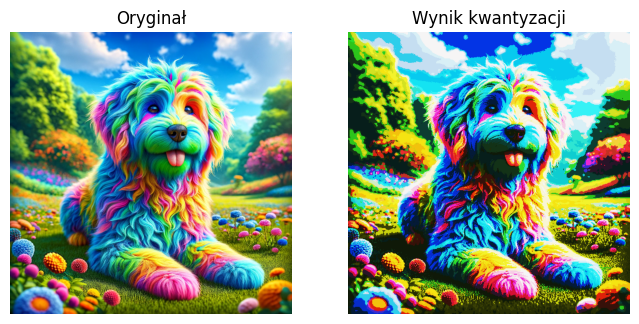

MSE: 1540.8981, max_color_cost: 87.4757, mean_color_cost: 58.2005
Score: 7363.2069
Finałowy wynik to: 6877.8652


In [24]:
if not FINAL_EVALUATION_MODE:
    print(f"Finałowy wynik to: {evaluate_algorithm(your_quantization_algorithm, 'valid_data'):.4f}")
